# Mining Gold with BXE, ROLR and RASCAL
---
Comparsion of different learning algorithms that exploit more information from the generator than the normal
BinaryCrossEntropy (BXE) classification method.<br>

Classifying for example particle events into two different categories (signal and background model) is equivalent to learning the likelihood ratio for two different hypotheses $\mathcal{H_0}$ and $\mathcal{H_1}$. <br>

The NP-Lemma states that this ratio is the best test statistic and hence giving a neural network the task to classify events it will basically learn the ratio.<br>

In particle physics it is often the case that we have access to the generators and could retrieve much more information and not just the in and output.<br>

This opens a door to a whole new range of learning/loss function. When extracting more information from the generator we can use our data more effectively such that our NN learns the likelihood ratio faster.<br>

Two of this methods (***ROLR*** and ***RASCAL***) are compared to the normal BXE loss, one would normally use to classify.<br>

(_Mining Gold_ should describe that less data is neededfor better results)

## Overview

***BXE***: BinaryCrossEntropy<br>

***ROLR***: Regression on Regression On Likelihood Ratio<br>
![](images/rolr.png)

***RASCAL***: Ratio And SCore Approximate Likelihood ratio<br>
![](images/rascal.png)

### Other methods:
***CASCAL***: CARL And SCore Approximate Likelihood ratio
![](images/cascal.png)

***SCANDAL***: SCore-Augmented Neural Density Approximates Likelihood
![](images/scandal.png)

***SALLY***: Score Approximates Likelihood LocallY<br>
***SALINO***: Score Approximates Likelihood Locally IN One dimension

### Import Modules

In [1]:
import torch
import pytorch_lightning as pl
import torch.nn as nn
from torch.optim import Adam
from torch.distributions import Normal
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

### Generate Data

#### Dataset
The mining procedure starts while generating the data. Additionally to the label to which model the certain event refer, also the score function and the ratio of the models can be calculated. These values are later used for the modification of the certain learning function.<br>

The data is drawn in a two step procedure.
1. Sample from gaussian with $\mu_0 = 0$ or $\mu_1 = 1$ and $\sigma_0 = 1$
2. Sample again from the same gaussians with $\sigma_1 = 0.1$

In [2]:
class GoldGenerator(Dataset):
    def __init__(self, 
                 generations=100) -> None:
        super().__init__()

        # dataset
        self.dataset = {}

        # num of points and generations
        self.data_points = 100
        self.generations = generations

        # theta hypothesis
        theta_0 = 0.0
        theta_1 = 1.0

        # std for data generation
        x_std = 0.1
        z_std = 1.0

        # distributions
        dist_0 = Normal(loc=theta_0, scale=z_std)
        dist_1 = Normal(loc=theta_1, scale=z_std)

        for gen_idx in range(self.generations):

            # target labels and parameter thetas
            theta_0_tensor = torch.zeros(self.data_points)
            theta_1_tensor = torch.ones(self.data_points)
            y = torch.vstack([theta_0_tensor[:int(self.data_points/2)],
                              theta_1_tensor[:int(self.data_points/2)]])

            # empty tensors
            X = torch.empty((self.data_points, 3))
            Y = torch.empty((self.data_points, 3))

            # from theta_0
            z0 = dist_0.rsample((int(self.data_points/2),))

            # from theta_1
            z1 = dist_1.rsample((int(self.data_points/2),))
            Z = torch.vstack([z0, z1])

            # from z0
            x0 = Normal(loc=z0, scale=x_std).rsample((1,))

            # from z1
            x1 = Normal(loc=z1, scale=x_std).rsample((1,))
            x = torch.hstack([x0, x1]).reshape((self.data_points,))
        
            X[:, 0] = x
            X[:, 1] = theta_0_tensor
            X[:, 2] = theta_1_tensor * theta_1  # for paramterization

            # ratio calculation
            r_xz = dist_0.log_prob(Z) - dist_1.log_prob(Z)

            # score calculation
            t_xz = (x - theta_0) / z_std**2


            # targets
            Y[:, 0] = y.reshape((self.data_points,))
            Y[:, 1] = r_xz.reshape((self.data_points,))
            Y[:, 2] = t_xz.reshape((self.data_points,))

            self.dataset[gen_idx] = (X, Y)

    def __len__(self):
        return self.generations

    def __getitem__(self, index):
        return self.dataset[index][0], self.dataset[index][1]


In [3]:
ds = GoldGenerator()
dl = DataLoader(dataset=ds,
                batch_size=16,
                shuffle=True)

### The Model

In [4]:
class Model(pl.LightningModule):
    def __init__(self,
                 regression_type="ROLR") -> None:
        super().__init__()

        # regression type -> "ROLR", "RASCAL", "BXE"
        self.regression_type = regression_type

        if self.regression_type == "RASCAL":
            # hyperparamter for RASCAL
            self.alpha = 0.01

        # total loss on epoch end
        self.total_loss = []
        self.mse = []
        self.epoch_end = False

        # efficiency
        self.efficiency_his = []

        # define network
        # three input features to make it 
        # parameterizable if wanted
        self.net = nn.Sequential(
            nn.Linear(3, 10),
            nn.PReLU(),
            nn.Linear(10, 10),
            nn.PReLU(),
            nn.Linear(10, 10),
            nn.PReLU(),
            nn.Linear(10, 1)
        )

        if self.regression_type == "BCE":
            self.net.append(nn.Sigmoid())

    def forward(self, x):
        output = self.net(x)
        return output

    def configure_optimizers(self):
        optim = Adam(self.parameters())
        return optim

    def training_step(self, train_batch, batch_idx):
        X, Y = train_batch

        # unpack Y
        targets, ratio, score = Y[:, :, 0].view(-1), Y[:, :, 1].view(-1).exp(), Y[:, :, 2].view(-1)

        # loss function
        if self.regression_type =="BCE":
            y_hat = self.net(X).view(-1)
            loss = nn.functional.binary_cross_entropy(torch.squeeze(y_hat, -1),targets)

        
        if self.regression_type in ["RASCAL", "ROLR"]:
            # output of the model
            ratio_hat = self.net(X).view(-1).exp()

            loss = torch.mean(targets * (
                ratio - ratio_hat)**2 + (1-targets) * (1/ratio - 1/ratio_hat)**2)
        
            if self.regression_type == "RASCAL":
                loss += self.alpha * torch.mean((1-targets)*(score - torch.autograd.functional.jvp(self.net, X, torch.ones_like(X))[1])**2)
            
        self.log("train_loss", loss)

        if self.epoch_end is True:
            self.total_loss.append(loss.detach().numpy())
            self.epoch_end = False

            x = torch.linspace(-0.5, 1.5, 1000)
            theta0 = torch.zeros_like(x)
            theta1 = torch.ones_like(x)

            X = torch.vstack([x, theta0, theta1]).T

            output = self.net(X).detach().numpy()

            if self.regression_type == "BCE":
                output = np.log((1-output)/output)
            
            true_llr = self.calculate_likelihood_ratio(x, 0.0, 1.0)
                
            self.mse.append(np.mean((output.reshape((1000,)) - true_llr.detach().numpy())**2))

        return loss

    def on_epoch_end(self):
        # toggle epoch end for easy loss display
        self.epoch_end = True
            
        return
    
    def calculate_likelihood_ratio(self, x, theta0, theta1):
        combined_std = (1.0**2 + 0.1**2) ** 0.5
        r_x = Normal(loc=theta0, scale=combined_std).log_prob(x) - Normal(loc=theta1, scale=combined_std).log_prob(x)
        return r_x


### ROLR (Regression on Regression On Likelihood Ratio)

In [5]:
model_rolr = Model(regression_type="ROLR")
trainer = pl.Trainer(max_epochs=200)
trainer.fit(model=model_rolr,
            train_dataloaders=dl)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/leonrenn/opt/miniconda3/envs/TorchExample/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1791: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/leonrenn/opt/miniconda3/envs/TorchExample/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:228: LightningDeprecationWarning: The `LightningModule.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `LightningModule.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
Missing logger folder: /Users/leonrenn/Documents/Programming/Python/Projects/MINING-GOLD-FROM-GENERATORS/lightning_logs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 274   
------------

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


#### Output

In [6]:
def calculate_likelihood_ratio(x, theta0, theta1):
    combined_std = (1.0**2 + 0.1**2) ** 0.5
    r_x = Normal(loc=theta0, scale=combined_std).log_prob(x) - Normal(loc=theta1, scale=combined_std).log_prob(x)
    return r_x

In [7]:
def gen_events(number_of_points, theta0=0.0, theta1=1.0):
    z0 = Normal(loc=theta0, scale=1.0).rsample((number_of_points,))
    z1 = Normal(loc=theta1, scale=1.0).rsample((number_of_points,))

    x0 = Normal(loc=z0, scale=0.1).rsample((1,))
    x1 = Normal(loc=z1, scale=0.1).rsample((1,))

    return x0, z1

In [8]:
def centralize_bins(bins):
    return (bins[1:] + bins[:-1])/2

0.6493427


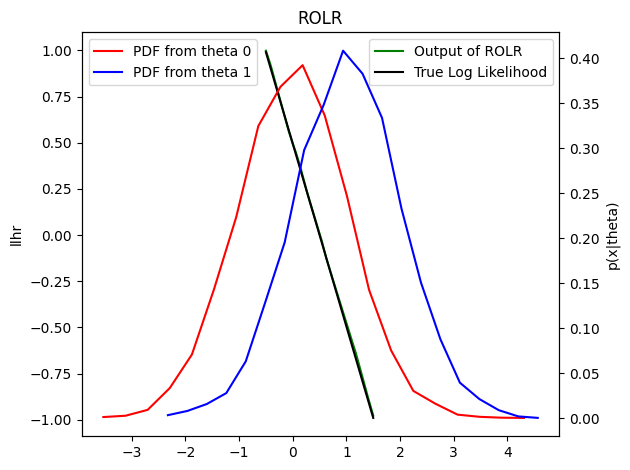

In [9]:
x = torch.linspace(-0.5, 1.5, 1000)
theta0 = torch.zeros_like(x)
theta1 = torch.ones_like(x)

x0, x1 = gen_events(10000)

hist0, bins0 = torch.histogram(x0, bins=20, density=True)
hist1, bins1 = torch.histogram(x1, bins=20, density=True)
cbins0 = centralize_bins(bins0)
cbins1 = centralize_bins(bins1)

X = torch.vstack([x, theta0, theta1]).T

output_rolr = model_rolr(X).detach().numpy()
true_llr = calculate_likelihood_ratio(x, 0.0, 1.0)

print(np.mean((output_rolr-true_llr.detach().numpy())**2))


fig, ax1 = plt.subplots()


ax1.plot(x, output_rolr, "g",label="Output of ROLR")
ax1.plot(x, true_llr, "k",label="True Log Likelihood")

ax1.legend(loc=1)

ax2 = ax1.twinx()

ax2.plot(cbins0, hist0, "r",label="PDF from theta 0")
ax2.plot(cbins1, hist1, "b",label="PDF from theta 1")

ax2.legend(loc=2)
plt.xlabel("x")
ax1.set_ylabel("llhr")
ax2.set_ylabel("p(x|theta)")
plt.title("ROLR")
fig.tight_layout()

### RASCAL (Ratio And SCore Approximate Likelihood ratio)

In [10]:
model_rascal = Model(regression_type="RASCAL")
trainer = pl.Trainer(max_epochs=200)
trainer.fit(model=model_rascal,
            train_dataloaders=dl)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 274   
------------------------------------
274       Trainable params
0         Non-trainable params
274       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


#### Output

0.66672385


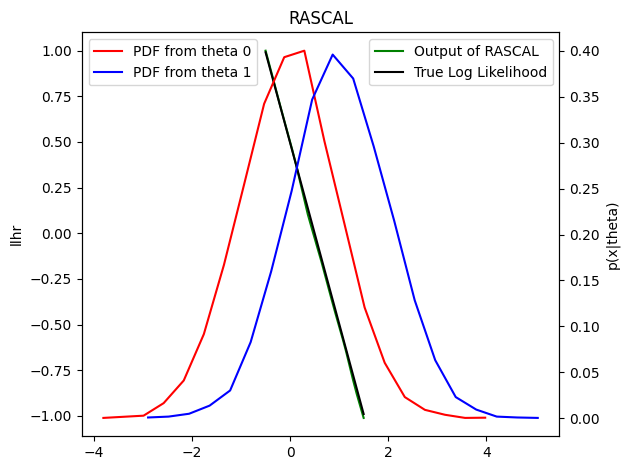

In [11]:
x = torch.linspace(-0.5, 1.5, 1000)
theta0 = torch.zeros_like(x)
theta1 = torch.ones_like(x)

x0, x1 = gen_events(10000)

hist0, bins0 = torch.histogram(x0, bins=20, density=True)
hist1, bins1 = torch.histogram(x1, bins=20, density=True)
cbins0 = centralize_bins(bins0)
cbins1 = centralize_bins(bins1)

X = torch.vstack([x, theta0, theta1]).T

output_rascal = model_rascal(X).detach().numpy()
true_llr = calculate_likelihood_ratio(x, 0.0, 1.0)

print(np.mean((output_rascal-true_llr.detach().numpy())**2))

fig, ax1 = plt.subplots()


ax1.plot(x, output_rascal, "g",label="Output of RASCAL")
ax1.plot(x, true_llr, "k",label="True Log Likelihood")

ax1.legend(loc=1)

ax2 = ax1.twinx()

ax2.plot(cbins0, hist0, "r",label="PDF from theta 0")
ax2.plot(cbins1, hist1, "b",label="PDF from theta 1")

ax2.legend(loc=2)
plt.xlabel("x")
ax1.set_ylabel("llhr")
ax2.set_ylabel("p(x|theta)")
plt.title("RASCAL")
fig.tight_layout()

### Normal (BXE)

In [12]:
model_bce = Model(regression_type="BCE")
trainer = pl.Trainer(max_epochs=200)
trainer.fit(model=model_bce,
            train_dataloaders=dl)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 274   
------------------------------------
274       Trainable params
0         Non-trainable params
274       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


0.69433683


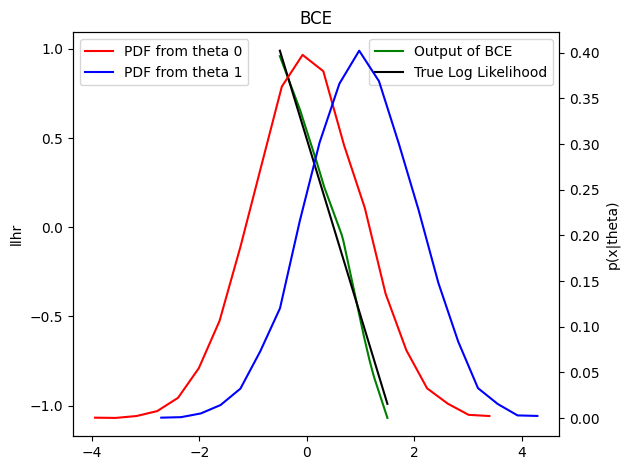

In [13]:
x = torch.linspace(-0.5, 1.5, 1000)
theta0 = torch.zeros_like(x)
theta1 = torch.ones_like(x)

x0, x1 = gen_events(10000)

hist0, bins0 = torch.histogram(x0, bins=20, density=True)
hist1, bins1 = torch.histogram(x1, bins=20, density=True)
cbins0 = centralize_bins(bins0)
cbins1 = centralize_bins(bins1)

X = torch.vstack([x, theta0, theta1]).T

output_bce = model_bce(X).detach().numpy()
llr = np.log((1-output_bce)/output_bce)
true_llr = calculate_likelihood_ratio(x, 0.0, 1.0)

print(np.mean((llr-true_llr.detach().numpy())**2))


fig, ax1 = plt.subplots()


ax1.plot(x, llr, "g",label="Output of BCE")
ax1.plot(x, true_llr, "k",label="True Log Likelihood")

ax1.legend(loc=1)

ax2 = ax1.twinx()

ax2.plot(cbins0, hist0, "r",label="PDF from theta 0")
ax2.plot(cbins1, hist1, "b",label="PDF from theta 1")

ax2.legend(loc=2)
plt.xlabel("x")
ax1.set_ylabel("llhr")
ax2.set_ylabel("p(x|theta)")
plt.title("BCE")
fig.tight_layout()

#### Comparison of Loss

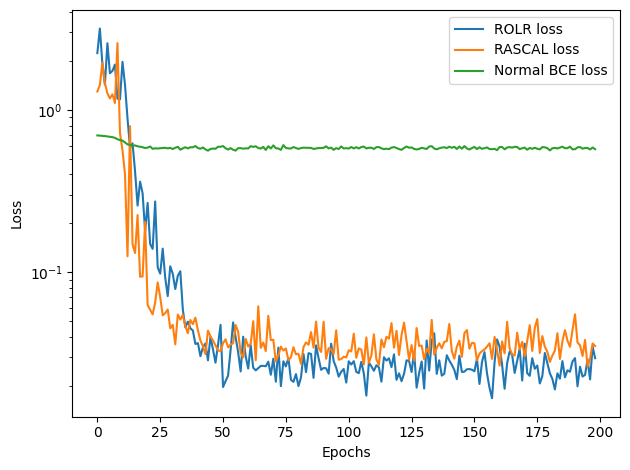

In [14]:
plt.plot(model_rolr.total_loss, label="ROLR loss")
plt.plot(model_rascal.total_loss, label="RASCAL loss")
plt.plot(model_bce.total_loss, label="Normal BCE loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.semilogy()
plt.legend()
plt.tight_layout()

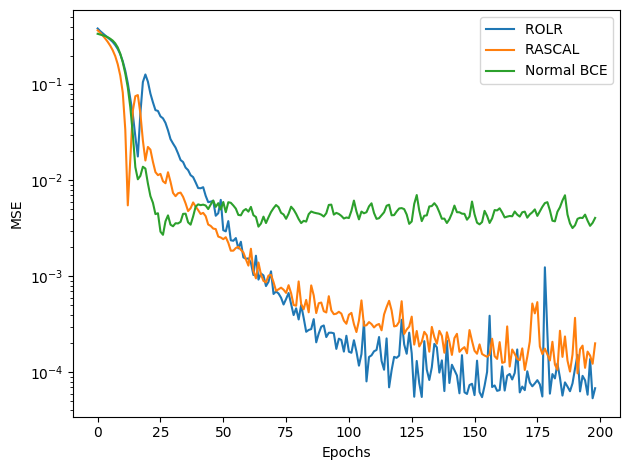

In [15]:
plt.plot(model_rolr.mse, label="ROLR ")
plt.plot(model_rascal.mse, label="RASCAL ")
plt.plot(model_bce.mse, label="Normal BCE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.semilogy()
plt.legend()
plt.tight_layout()

### Likelihood Ratios

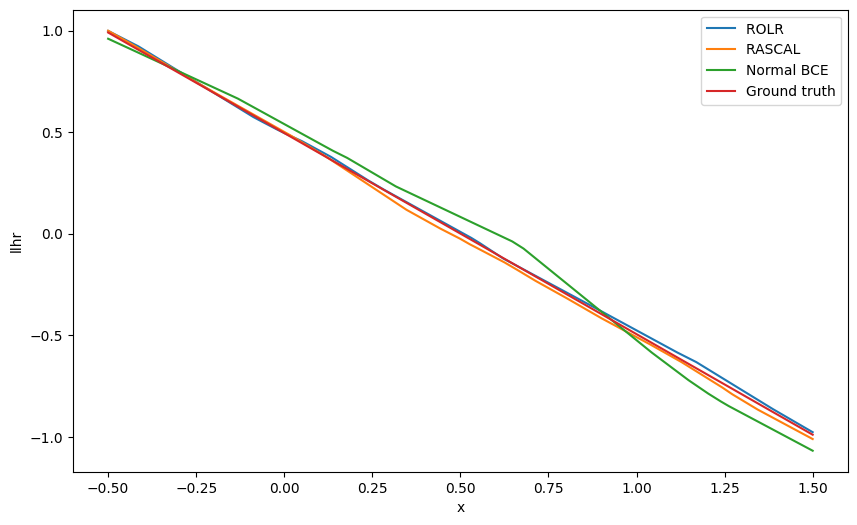

In [19]:
plt.figure(figsize=(10,6))
plt.plot(x, output_rolr, label="ROLR ")
plt.plot(x, output_rascal, label="RASCAL ")
plt.plot(x, llr, label="Normal BCE")
plt.plot(x, true_llr, label="Ground truth")
plt.xlabel("x")
plt.ylabel("llhr")
plt.legend()
plt.show()

## Summary

The methods proposed in the paper not only accelerate training compared to the BXE, but also have better results in the end which can be seen by the total MSE for the likelihood ratio fit.<br>
Next steps would be to do this for all named learning functions and parameterize the neural network for different null and alternative hypothesis.